In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wavespeed_for_alpha(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    alpha=0.5,
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="plasma",
    levels=20,
    # fonts to match your grid defaults
    tick_fs=13, label_fs=18, title_fs=20, cbar_fs=13,
    # layout/title
    title=None,                        # panel title (defaults to pretty α)
    suptitle=None,                     # optional big title above
    suptitle_y=0.98,
    cbar_label="Estimated wave speed",
    fig_size=(7.0, 5.2),
    save=False, outpath=None,
    debug=False,
):
    """
    Single heatmap: wave speed vs log10(lambda) (x) and m0 (y) at a fixed alpha.
    """
    roots = _augment_roots(base_dirs)

    lambda_vals = np.asarray(lambda_vals, float)
    m0_vals     = np.asarray(m0_vals, float)

    X, Y = np.meshgrid(np.log10(lambda_vals), m0_vals)  # X: log10(λ), Y: m0

    # Fill H(m0, lambda) with merged speeds
    H = np.full((len(m0_vals), len(lambda_vals)), np.nan, float)
    for i, m0 in enumerate(m0_vals):
        for j, lam in enumerate(lambda_vals):
            val = _merge_speed_from_roots(roots, lam, float(alpha), float(m0), which=which_speed)
            H[i, j] = val
            if debug and not np.isfinite(val):
                print(f"[warn] missing: α={alpha:g}, m0={m0:g}, λ={lam:g}")

    Hm = np.ma.masked_invalid(H)

    # Per-panel autoscale (like your grids)
    if np.isfinite(Hm).any():
        vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
        if vmin == vmax:
            vmax = vmin + 1e-9
    else:
        vmin, vmax = 0.0, 1.0

    fig, ax = plt.subplots(1, 1, figsize=fig_size)

    cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

    # Colorbar with 4 concise ticks
    cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
    ticks = [vmin, vmin + (vmax - vmin)/3.0, vmin + 2.0*(vmax - vmin)/3.0, vmax]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{float(t):.2f}" for t in ticks])
    cbar.ax.tick_params(labelsize=cbar_fs)
    cbar.set_label(cbar_label, fontsize=cbar_fs)

    # Titles and labels
    panel_title = _alpha_title(alpha) if title is None else title
    ax.set_title(panel_title, fontsize=title_fs)

    ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    ax.set_ylabel(r"$m_0$", fontsize=label_fs)

    # X ticks: decades; Y ticks: all m0 (or thin if you prefer)
    xticks = np.unique(np.floor(np.log10(lambda_vals)).astype(int))
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{d:d}" for d in xticks], fontsize=tick_fs)
    ax.tick_params(axis="y", labelsize=tick_fs)

    if suptitle:
        fig.suptitle(suptitle, fontsize=label_fs + 10, fontweight="bold", y=suptitle_y)

    fig.tight_layout(rect=[0, 0, 1, 0.93 if suptitle else 1])

    if save:
        outpath = outpath or f"heatmap_alpha_{alpha:g}.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    return fig, ax

[plot] saved to heatmap_alpha_0p5.png


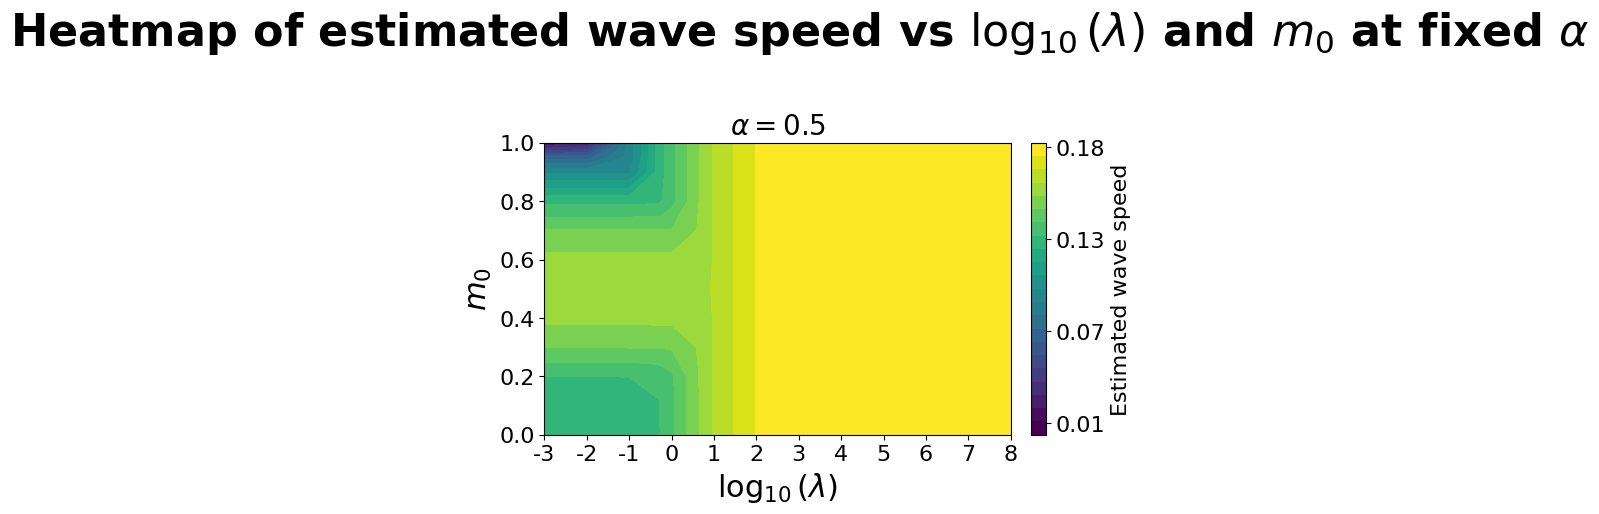

In [33]:
fig, ax = plot_wavespeed_for_alpha(
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    alpha=0.5,
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="viridis",
    levels=20,
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
    suptitle=r"Heatmap of estimated wave speed vs $\log_{10}(\lambda)$ and $m_0$ at fixed $\alpha$",
    suptitle_y=0.98,
    cbar_label="Estimated wave speed",
    save=True, outpath="heatmap_alpha_0p5.png"
)

<h2> Grids

In [1]:
# =======================
# Wavespeed merge + plots
# =======================
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Formatting + path helpers
# -------------------------
def _fmt_exact(v) -> str:
    """Exact token: 10 -> '10', 0.001 -> '0.001' (no sci-notation)."""
    v = float(v)
    if v.is_integer():
        return str(int(v))
    s = f"{v:.12f}".rstrip("0").rstrip(".")
    return "0" if s == "-0" else s

def _fmt_val(v):
    """Compact label in folder names: keeps ints clean (e.g., 10 not 10.0)."""
    if isinstance(v, (int, np.integer)) or (isinstance(v, float) and v.is_integer()):
        return f"{int(v)}"
    s = f"{v}"
    return s.rstrip('0').rstrip('.') if '.' in s else s

def _run_dir_exact(root, lam, alpha, m0):
    """
    EXACT directory layout:
      <root>/lambda_<val>/alpha_<val>/m0_<val>
    Returns Path or None.
    """
    d = Path(root) / f"lambda_{_fmt_exact(lam)}" / f"alpha_{_fmt_exact(alpha)}" / f"m0_{_fmt_exact(m0)}"
    return d if d.is_dir() else None

# -------------------------
# Speed readers (summary/fronts/snapshots)
# -------------------------
def _slope_vs_time(t, xf, last_frac=0.5):
    t = np.asarray(t, float); xf = np.asarray(xf, float)
    if len(t) < 4 or len(xf) != len(t): return np.nan
    i0 = max(0, int((1.0 - last_frac) * len(t)))
    t_use = t[i0:]; x_use = xf[i0:]
    ok = np.isfinite(t_use) & np.isfinite(x_use)
    if ok.sum() < 3: return np.nan
    A = np.vstack([t_use[ok], np.ones(ok.sum())]).T
    slope, _ = np.linalg.lstsq(A, x_use[ok], rcond=None)[0]
    return float(slope)

def _speed_from_fronts_npz(npz_path):
    """Compute speed from fronts_*.npz via linear fit of x_front(t)."""
    try:
        z = np.load(npz_path, allow_pickle=True)
    except Exception:
        return np.nan
    t = None; xf = None
    for tk in ("t","time","times","T","t_fronts"):
        if tk in z.files: t = z[tk]; break
    for fk in ("x_front","xfront","front","fronts","front_positions","xf","x_fronts"):
        if fk in z.files: xf = z[fk]; break
    if t is None or xf is None: return np.nan
    xf = np.asarray(xf)
    if xf.ndim > 1:
        # pick last column/axis if matrix-like
        xf = xf[..., -1].squeeze()
    return _slope_vs_time(t, xf, last_frac=0.5)

def _speed_from_snapshots_npz(npz_path, threshold=0.5):
    """Fallback: compute speed from snapshots.npz (x, N_arr/u_arr, times)."""
    try:
        z = np.load(npz_path, allow_pickle=True)
    except Exception:
        return np.nan
    x = z.get("x", z.get("X", None))
    u = z.get("N_arr", z.get("u_arr", z.get("N", None)))
    t = z.get("times", z.get("t", z.get("T", None)))
    if x is None or u is None or t is None:
        return np.nan
    x = np.asarray(x); t = np.asarray(t); U = np.asarray(u)
    if U.ndim != 2 or len(t) < 5: return np.nan
    i0 = len(t)//2
    t_use = t[i0:]; x_front = []
    for k in range(i0, len(t)):
        uk = U[k]
        idx = np.where((uk[:-1]-threshold)*(uk[1:]-threshold) <= 0)[0]
        if len(idx)==0: x_front.append(np.nan); continue
        j = idx[0]; xj,xj1 = x[j],x[j+1]; uj,uj1 = uk[j],uk[j+1]
        frac = 0.0 if uj1==uj else (threshold-uj)/(uj1-uj)
        x_front.append(xj + frac*(xj1-xj))
    return _slope_vs_time(t_use, np.asarray(x_front,float), last_frac=1.0)

def _speed_from_summary_json(dirpath, which="N"):
    f = Path(dirpath) / "summary.json"
    if not f.is_file(): return np.nan
    try:
        obj = json.loads(f.read_text())
    except Exception:
        return np.nan
    w = str(which).upper()
    keys = ["speed","c","wave_speed"]
    if w == "N": keys = ["speed_N","c_N"] + keys
    if w == "M": keys = ["speed_M","c_M"] + keys
    for k in keys:
        if k in obj:
            try:
                val = float(obj[k])
                if np.isfinite(val): return val
            except Exception:
                pass
    # common key your runner writes
    if "wave_speed" in obj:
        try:
            val = float(obj["wave_speed"])
            if np.isfinite(val): return val
        except Exception:
            pass
    return np.nan

def _load_speed(dirpath, which="N"):
    """
    Priority inside EXACT dir:
      1) summary.json
      2) fronts_{N|M}.npz (then generic fronts*.npz)
      3) snapshots.npz
    Returns float or np.nan.
    """
    if dirpath is None: return np.nan
    d = Path(dirpath)
    if not d.is_dir(): return np.nan

    # 1) summary.json
    val = _speed_from_summary_json(d, which=which)
    if np.isfinite(val): return val

    # 2) fronts
    prefer = []
    if str(which).upper() == "N":
        prefer += ["fronts_N.npz", "front_N.npz"]
    else:
        prefer += ["fronts_M.npz", "front_M.npz"]
    prefer += ["fronts.npz", "front.npz", "front_positions.npz"]
    for name in prefer:
        f = d / name
        if f.is_file():
            val = _speed_from_fronts_npz(f)
            if np.isfinite(val): return val

    # any other front*.npz
    for f in sorted(d.glob("front*.npz")):
        val = _speed_from_fronts_npz(f)
        if np.isfinite(val): return val

    # 3) snapshots
    snap = d / "snapshots.npz"
    if snap.is_file():
        val = _speed_from_snapshots_npz(snap)
        if np.isfinite(val): return val

    return np.nan

# -------------------------
# α label helper (pretty titles)
# -------------------------
def _alpha_title(a):
    """
    Returns a nice title string for α, e.g.
      α = 0.1, α = 10^4, α = 2.5×10^3
    """
    a = float(a)
    if a == 0:
        return r"$\alpha=0$"
    exp = int(np.floor(np.log10(abs(a))))
    mant = abs(a) / (10**exp)
    sign = "-" if a < 0 else ""
    # if mantissa ~ 1, use pure power
    if np.isclose(mant, 1.0, rtol=1e-10, atol=1e-12):
        return rf"$\alpha={sign}10^{{{exp}}}$"
    # small values: keep plain if within [1e-2, 1e2]
    if 1e-2 <= abs(a) <= 1e2:
        return rf"$\alpha={a:g}$"
    return rf"$\alpha={sign}{mant:.2g}\times 10^{{{exp}}}$"

# -------------------------
# Root handling + merge
# -------------------------
def _augment_roots(base_dirs):
    """
    Return an ordered tuple of roots, automatically prepending 'speeds_func_4'
    if that directory exists.
    """
    roots = [Path(p) for p in base_dirs]
    special = Path("speeds_func_4")
    if special.is_dir():
        if all(r.resolve() != special.resolve() for r in roots):
            roots = [special] + roots
    return tuple(roots)

def _merge_speed_from_roots(
    roots,
    lam,
    alpha,
    m0,
    which="N",
    cutoff=0.5,
    allow_cross_fallback=True,
    verbose=False,
):
    """
    Lookup wave speed for (lam, alpha, m0) across multiple root stores.

    Selection logic:
      - If a root named like 'speeds_func_4' exists AND alpha≈1e4, try that first.
      - Otherwise:
          * if m0 < cutoff -> prefer any root whose name contains '_l'
          * if m0 >= cutoff -> prefer any root whose name contains '_u'
        Then try remaining roots as fallbacks.
      - If primary lookup fails and allow_cross_fallback=True, try the other halves too.

    Returns float or np.nan.
    """
    def _locate_dir(root: Path, lam, alpha, m0):
        # 1) exact-style path
        d = _run_dir_exact(root, lam, alpha, m0)
        if d is not None:
            return d
        # 2) _fmt_val-style path (your saving helper)
        lam_dir   = root / f"lambda_{_fmt_val(lam)}"
        alpha_dir = lam_dir / f"alpha_{_fmt_val(alpha)}"
        m0_dir    = alpha_dir / f"m0_{_fmt_val(m0)}"
        return m0_dir if m0_dir.is_dir() else None

    roots = tuple(Path(r) for r in roots)

    # Build candidate root order
    candidate_roots = []
    alpha_is_1e4 = np.isclose(float(alpha), 1e4, rtol=0, atol=1e-12)
    if alpha_is_1e4:
        for r in roots:
            if "func_4" in r.name:  # robust match for 'speeds_func_4'
                candidate_roots.append(r)

    side_pref = "_l" if float(m0) < float(cutoff) else "_u"
    for r in roots:
        if side_pref in r.name and r not in candidate_roots:
            candidate_roots.append(r)

    if allow_cross_fallback:
        other = "_u" if side_pref == "_l" else "_l"
        for r in roots:
            if other in r.name and r not in candidate_roots:
                candidate_roots.append(r)

    # Append any remaining roots
    for r in roots:
        if r not in candidate_roots:
            candidate_roots.append(r)

    # Try in order
    for root in candidate_roots:
        d = _locate_dir(root, lam, alpha, m0)
        if verbose:
            print(f"[lookup] α={alpha:g}, m0={m0:g}, λ={lam:g} -> {root.name}{' (found dir)' if d else ' (no dir)'}")
        if d is None:
            continue
        val = _load_speed(d, which=which)
        if np.isfinite(val):
            if verbose:
                print(f"[found] {root.name}: {val}")
            return val

    if verbose:
        tried = " -> ".join(r.name for r in candidate_roots)
        print(f"[miss] α={alpha:g}, m0={m0:g}, λ={lam:g} | tried: {tried}")
    return np.nan

# -------------------------
# Heatmap grid plot
# -------------------------
def plot_wavespeed_alpha_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alpha_rows=((1e-3, 1e-2, 1e-1), (1e3, 1e4, 1e5)),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="plasma",
    levels=20,
    fig_size=(18, 9),
    # ---- unified font control ----
    font_scale=1.0,
    tick_fs=None,
    label_fs=None,
    title_fs=None,
    cbar_fs=None,
    suptitle=None,
    debug=False
):
    """
    Draw a grid of wavespeed heatmaps vs λ (x) and m0 (y) for multiple α values.
    Colorbar ticks are reduced to [min, min+1/3Δ, min+2/3Δ, max] per panel.
    """
    # auto-join speeds_func_4 (if present) before everything else
    roots = _augment_roots(base_dirs)

    # Resolve fonts
    tick_fs  = int(round((tick_fs  if tick_fs  is not None else 11) * font_scale))
    label_fs = int(round((label_fs if label_fs is not None else 14) * font_scale))
    title_fs = int(round((title_fs if title_fs is not None else 16) * font_scale))
    cbar_fs  = int(round((cbar_fs  if cbar_fs is not None else 12) * font_scale))
    suptitle_text = suptitle if suptitle is not None else r"Wave speed heatmaps for $\lambda$ vs $m_0$ across $\alpha$"

    alpha_rows  = tuple(tuple(float(a) for a in row) for row in alpha_rows)
    m0_vals     = np.asarray(m0_vals, dtype=float)
    lambda_vals = np.asarray(lambda_vals, dtype=float)

    X, Y = np.meshgrid(np.log10(lambda_vals), m0_vals)

    # Precompute H per panel (EXACT lookups)
    H_mats = []
    for row in alpha_rows:
        row_mats = []
        for alpha in row:
            H = np.full((len(m0_vals), len(lambda_vals)), np.nan, dtype=float)
            for i, m0 in enumerate(m0_vals):
                for j, lam in enumerate(lambda_vals):
                    val = _merge_speed_from_roots(roots, lam, alpha, m0, which=which_speed)
                    H[i, j] = val
                    if debug:
                        print(f"root=* exact, α={alpha:g}, m0={m0:g}, λ={lam:g} -> {val}")
            row_mats.append(H)
        H_mats.append(row_mats)

    nrows, ncols = len(alpha_rows), len(alpha_rows[0])
    fig, axes = plt.subplots(nrows, ncols, figsize=fig_size, constrained_layout=True, squeeze=False)

    for r in range(nrows):
        for c in range(ncols):
            ax = axes[r, c]
            H  = H_mats[r][c]
            Hm = np.ma.masked_invalid(H)

            # Per-panel autoscale
            if np.isfinite(Hm).any():
                vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
                if vmin == vmax:
                    vmax = vmin + 1e-9
            else:
                vmin, vmax = 0.0, 1.0

            cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

            # Per-panel colorbar with only 4 ticks: min, 2 mids, max
            cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
            ticks = [vmin,
                     vmin + (vmax - vmin) / 3.0,
                     vmin + 2.0 * (vmax - vmin) / 3.0,
                     vmax]
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([f"{float(t):.2f}" for t in ticks])
            cbar.ax.tick_params(labelsize=cbar_fs)
            ##cbar.set_label("Estimated wave speed", fontsize=cbar_fs)
            cbar.set_label(r"Estimated wave speed", fontsize=cbar_fs)

            ax.set_title(_alpha_title(alpha_rows[r][c]), fontsize=title_fs)

            # Axes labeling
            if r == nrows - 1:
                ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
            else:
                ax.set_xticklabels([])

            if c == 0:
                ax.set_ylabel(r"$m_0$", fontsize=label_fs)
            else:
                ax.set_yticklabels([])

            # Decade ticks along x
            decades = np.unique(np.floor(np.log10(lambda_vals)).astype(int))
            ax.set_xticks(decades)
            ax.set_xticklabels([f"{d:d}" for d in decades], fontsize=tick_fs)
            ax.tick_params(axis="y", labelsize=tick_fs)

    fig.suptitle(suptitle_text, fontsize=label_fs + int(round(10 * font_scale)), fontweight='bold')
    plt.show()
    return fig, axes

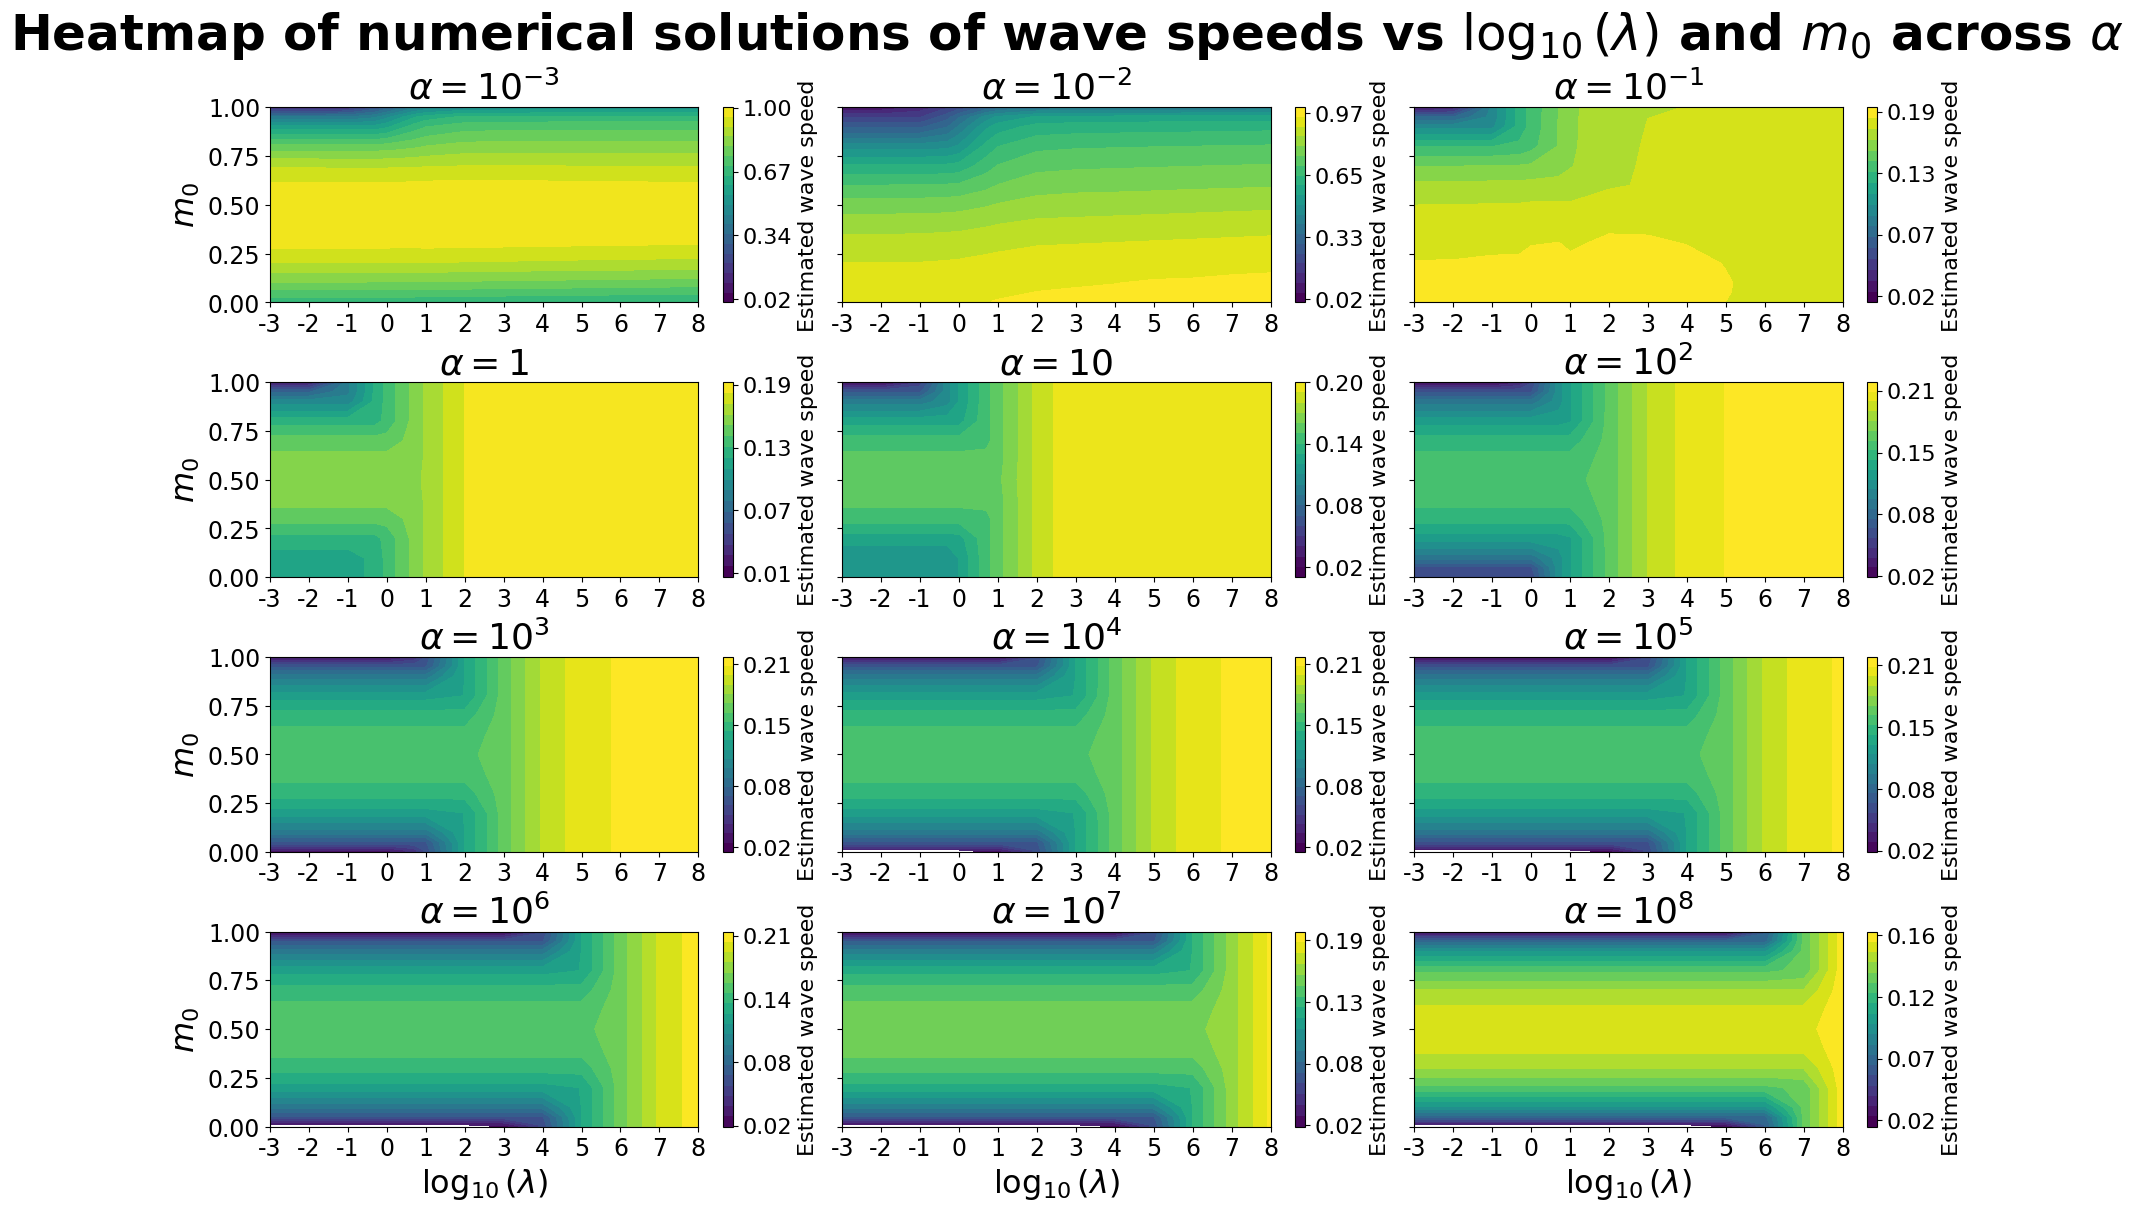

(<Figure size 1800x1200 with 24 Axes>,
 array([[<Axes: title={'center': '$\\alpha=10^{-3}$'}, ylabel='$m_0$'>,
         <Axes: title={'center': '$\\alpha=10^{-2}$'}>,
         <Axes: title={'center': '$\\alpha=10^{-1}$'}>],
        [<Axes: title={'center': '$\\alpha=1$'}, ylabel='$m_0$'>,
         <Axes: title={'center': '$\\alpha=10$'}>,
         <Axes: title={'center': '$\\alpha=10^{2}$'}>],
        [<Axes: title={'center': '$\\alpha=10^{3}$'}, ylabel='$m_0$'>,
         <Axes: title={'center': '$\\alpha=10^{4}$'}>,
         <Axes: title={'center': '$\\alpha=10^{5}$'}>],
        [<Axes: title={'center': '$\\alpha=10^{6}$'}, xlabel='$\\log_{10}(\\lambda)$', ylabel='$m_0$'>,
         <Axes: title={'center': '$\\alpha=10^{7}$'}, xlabel='$\\log_{10}(\\lambda)$'>,
         <Axes: title={'center': '$\\alpha=10^{8}$'}, xlabel='$\\log_{10}(\\lambda)$'>]],
       dtype=object))

In [25]:
base_dirs = ("speeds_func_l", "speeds_func_u", "speeds_func_4")
alpha_rows = ((1e-3, 1e-2, 1e-1), (1, 1e1, 1e2), (1e3, 1e4, 1e5), (1e6, 1e7, 1e8))
lambda_vals = (1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8)
m0_vals = (0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1)
plot_wavespeed_alpha_grid(
    base_dirs=base_dirs,
    alpha_rows=alpha_rows,
    lambda_vals=lambda_vals,
    m0_vals=m0_vals,
    which_speed="N",
    cmap="viridis",
    levels=20,
    fig_size=(18, 12),
    font_scale=1.3,
    suptitle = r"Heatmap of numerical solutions of wave speeds vs $\log_{10}(\lambda)$ and $m_0$ across $\alpha$",
    debug=False,
    tick_fs=13, label_fs=18, title_fs=20, cbar_fs=12
)

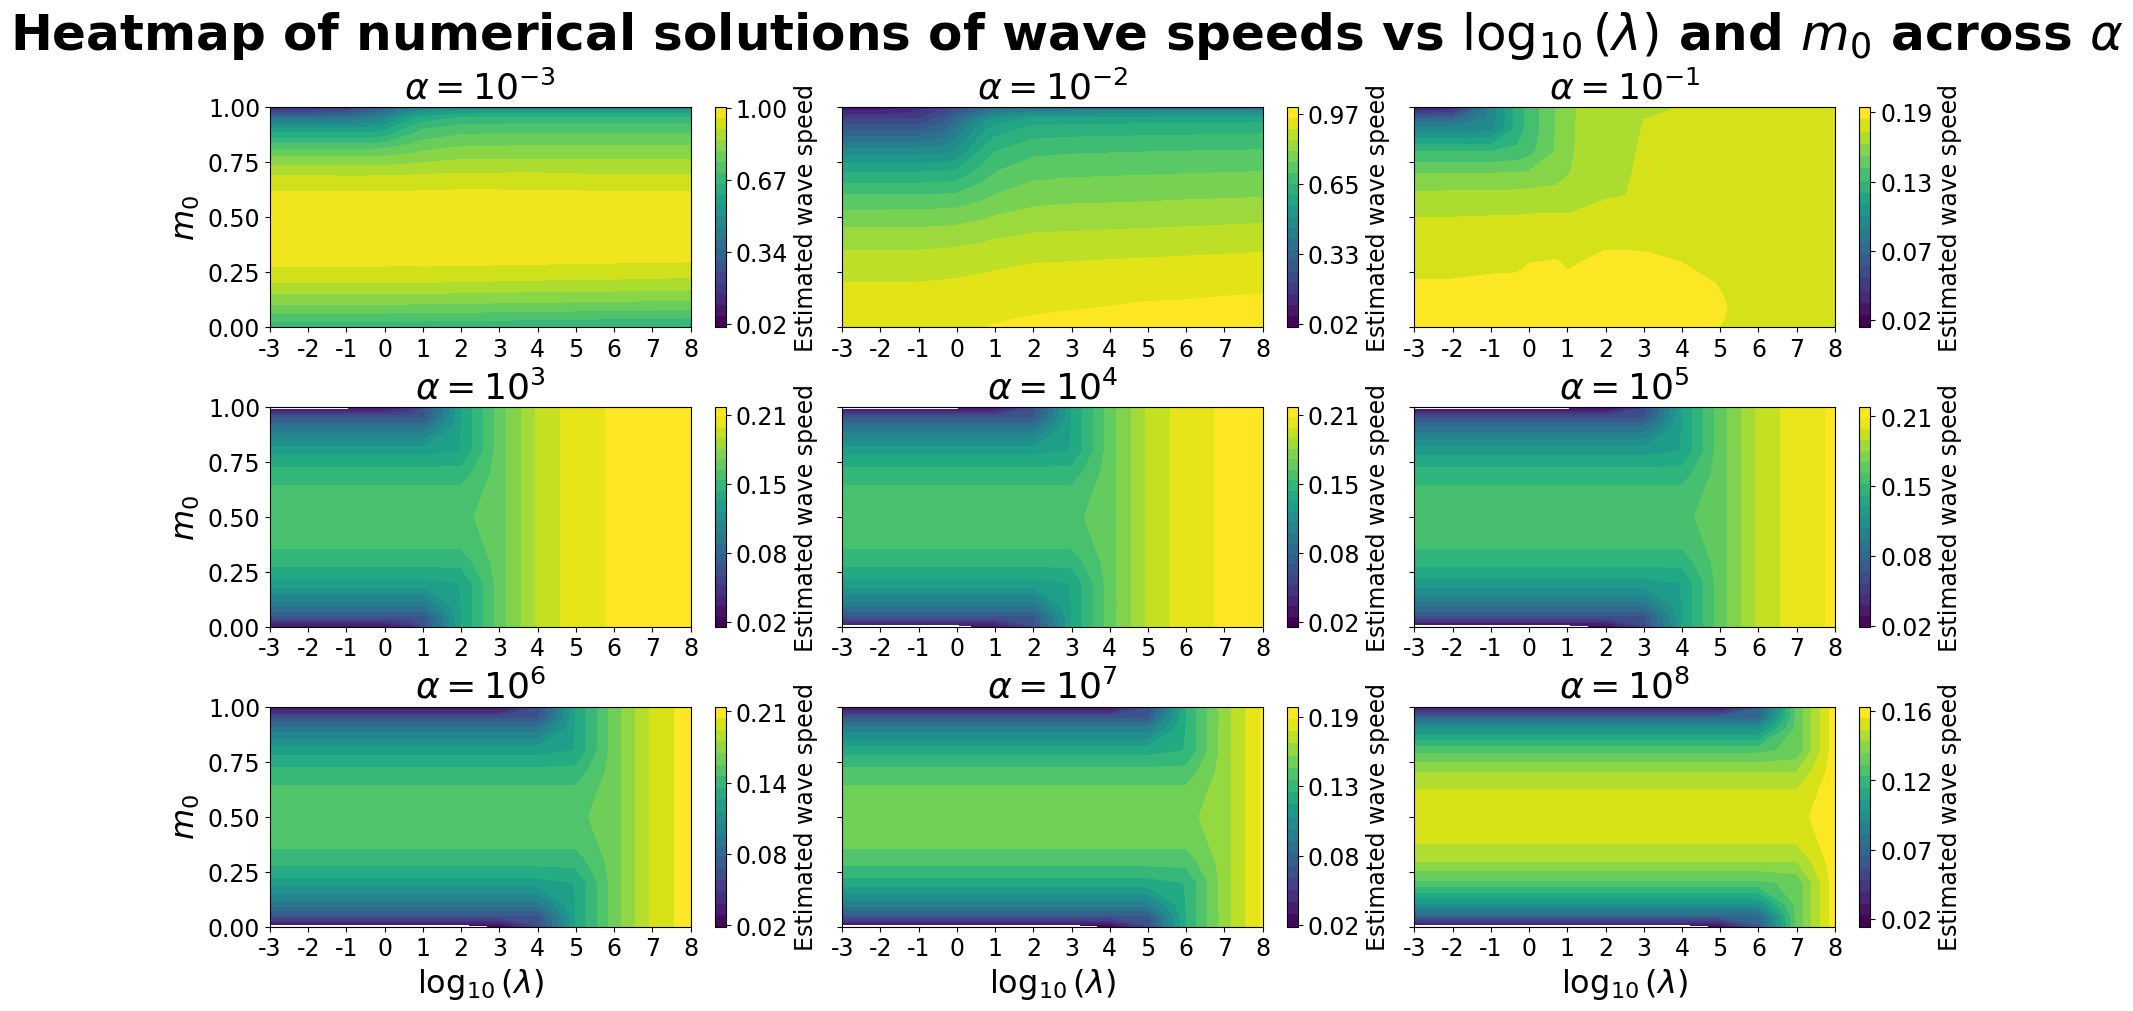

(<Figure size 1800x1000 with 18 Axes>,
 array([[<Axes: title={'center': '$\\alpha=10^{-3}$'}, ylabel='$m_0$'>,
         <Axes: title={'center': '$\\alpha=10^{-2}$'}>,
         <Axes: title={'center': '$\\alpha=10^{-1}$'}>],
        [<Axes: title={'center': '$\\alpha=10^{3}$'}, ylabel='$m_0$'>,
         <Axes: title={'center': '$\\alpha=10^{4}$'}>,
         <Axes: title={'center': '$\\alpha=10^{5}$'}>],
        [<Axes: title={'center': '$\\alpha=10^{6}$'}, xlabel='$\\log_{10}(\\lambda)$', ylabel='$m_0$'>,
         <Axes: title={'center': '$\\alpha=10^{7}$'}, xlabel='$\\log_{10}(\\lambda)$'>,
         <Axes: title={'center': '$\\alpha=10^{8}$'}, xlabel='$\\log_{10}(\\lambda)$'>]],
       dtype=object))

In [21]:
base_dirs = ("speeds_func_l", "speeds_func_u", "speeds_func_4")
alpha_rows = ((1e-3, 1e-2, 1e-1), (1e3, 1e4, 1e5), (1e6, 1e7, 1e8))
lambda_vals = (1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8)
m0_vals = (0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1)
plot_wavespeed_alpha_grid(
    base_dirs=base_dirs,
    alpha_rows=alpha_rows,
    lambda_vals=lambda_vals,
    m0_vals=m0_vals,
    which_speed="N",
    cmap="viridis",
    levels=20,
    fig_size=(18, 10),
    font_scale=1.3,
    suptitle = r"Heatmap of numerical solutions of wave speeds vs $\log_{10}(\lambda)$ and $m_0$ across $\alpha$",
    debug=False,
    tick_fs=13, label_fs=18, title_fs=20, cbar_fs=13
)

In [3]:
import matplotlib.ticker as mticker

def plot_lambda_lines_by_m0_grid(
    base_dirs=("speeds_func_l", "speeds_func_u"),
    alphas=(1e-3, 1e-1, 1e3, 1e6),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="viridis",
    lw=2.5, ms=6,
    # fonts (defaults aligned with your heatmap call)
    font_scale=1.0,
    tick_fs=13, label_fs=18, title_fs=20, legend_fs=12,
    # legend placement
    legend_side="right",                 # "right" or "bottom"
    legend_bbox_right=(.9, 0.5),
    legend_bbox_bottom=(0.5, -0.06),
    legend_ncol_bottom=8,
    # y-axis behavior
    sharey=False,
    show_all_y_ticks=True,
    ylabel_all=True,
    # figure title controls
    suptitle=r"Wavespeed vs $\log_{10}(\lambda)$ across $\alpha$",
    suptitle_y=1.03,                     # raise the title a bit
    suptitle_weight="bold",              # make the title bold
    save=False, outpath=None,
    debug=False
):
    roots = _augment_roots(base_dirs)

    # -- Fonts (apply global multiplier)
    base_tick, base_label, base_title, base_legend = tick_fs, label_fs, title_fs, legend_fs
    tick_fs   = int(round(base_tick   * font_scale))
    label_fs  = int(round(base_label  * font_scale))
    title_fs  = int(round(base_title  * font_scale))
    legend_fs = int(round(base_legend * font_scale))

    alphas = tuple(float(a) for a in alphas)
    m0_vals = np.asarray(m0_vals, float)
    lambdas = list(lambda_vals)

    # auto-insert λ=1e4 if α=1e4 requested
    if any(np.isclose(a, 1e4, rtol=0, atol=1e-12) for a in alphas):
        if not any(np.isclose(l, 1e4, rtol=0, atol=1e-12) for l in lambdas):
            lambdas.append(1e4)
    lambdas = np.asarray(sorted(lambdas, key=float), float)
    log_lambda = np.log10(lambdas)

    # Colors
    cmap_obj = plt.get_cmap(cmap)
    colors = [cmap_obj(i / max(1, len(m0_vals)-1)) for i in range(len(m0_vals))]

    nA = len(alphas)
    fig_h = 4.8
    fig_w = 5.4 * nA
    fig, axes = plt.subplots(1, nA, figsize=(fig_w, fig_h), sharey=sharey, squeeze=False)
    axes = axes[0]

    handles, labels = [], []
    total_missing = 0

    for idx, alpha in enumerate(alphas):
        ax = axes[idx]

        for k, m0 in enumerate(m0_vals):
            ys = []
            for lam in lambdas:
                val = _merge_speed_from_roots(roots, lam, alpha, m0, which=which_speed)
                ys.append(val)
                if debug and not np.isfinite(val):
                    print(f"[warn] missing: α={alpha:g}, m0={m0:g}, λ={lam:g}")
                if not np.isfinite(val):
                    total_missing += 1
            ys = np.asarray(ys, float)
            h, = ax.plot(log_lambda, ys, "-o", color=colors[k], lw=lw, ms=ms, label=rf"{m0:g}")
            ##if ylabel_all or idx == 0:
            if idx == 0:
                handles.append(h); labels.append(rf"{m0:g}")

        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.2f}".rstrip("0").rstrip(".")))
        ax.set_title(_alpha_title(alpha), fontsize=title_fs, fontweight="bold")
        ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
        if idx == 0:
            ax.set_ylabel("Estimated wave speed", fontsize=label_fs)

        ax.tick_params(axis="both", labelsize=tick_fs)

        xticks = np.arange(np.floor(min(log_lambda)), np.ceil(max(log_lambda))+1).astype(int)
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{d:d}" for d in xticks], fontsize=tick_fs)

        ax.grid(True, linestyle="--", alpha=0.25)

    # shared legend
    if legend_side.lower() == "right":
        fig.legend(
            handles, labels, title=r"$m_0$",
            fontsize=legend_fs, title_fontsize=legend_fs,
            loc="center left", bbox_to_anchor=legend_bbox_right
        )
        # leave extra room on right & top for raised suptitle
        fig.tight_layout(rect=[0, 0, 0.95, 0.92])
    else:
        fig.legend(
            handles, labels, title=r"$m_0$",
            fontsize=legend_fs, title_fontsize=legend_fs,
            loc="upper center", bbox_to_anchor=legend_bbox_bottom, ncol=legend_ncol_bottom
        )
        fig.tight_layout(rect=[0, 0.08, 1, 0.92])

    # figure title (raised & bold)
    if suptitle:
        fig.suptitle(suptitle, fontsize=label_fs + 10, y=suptitle_y, fontweight=suptitle_weight)

    if save:
        outpath = outpath or "speed_vs_loglambda_grid.png"
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    if total_missing:
        print(f"[info] total missing/NaN points encountered: {total_missing}")

    return fig, axes

[plot] saved to speed_vs_loglambda_grid.png
[info] total missing/NaN points encountered: 19


(<Figure size 2160x480 with 4 Axes>,
 array([<Axes: title={'center': '$\\alpha=10^{-3}$'}, xlabel='$\\log_{10}(\\lambda)$', ylabel='Estimated wave speed'>,
        <Axes: title={'center': '$\\alpha=10^{-1}$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=10^{3}$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=10^{6}$'}, xlabel='$\\log_{10}(\\lambda)$'>],
       dtype=object))

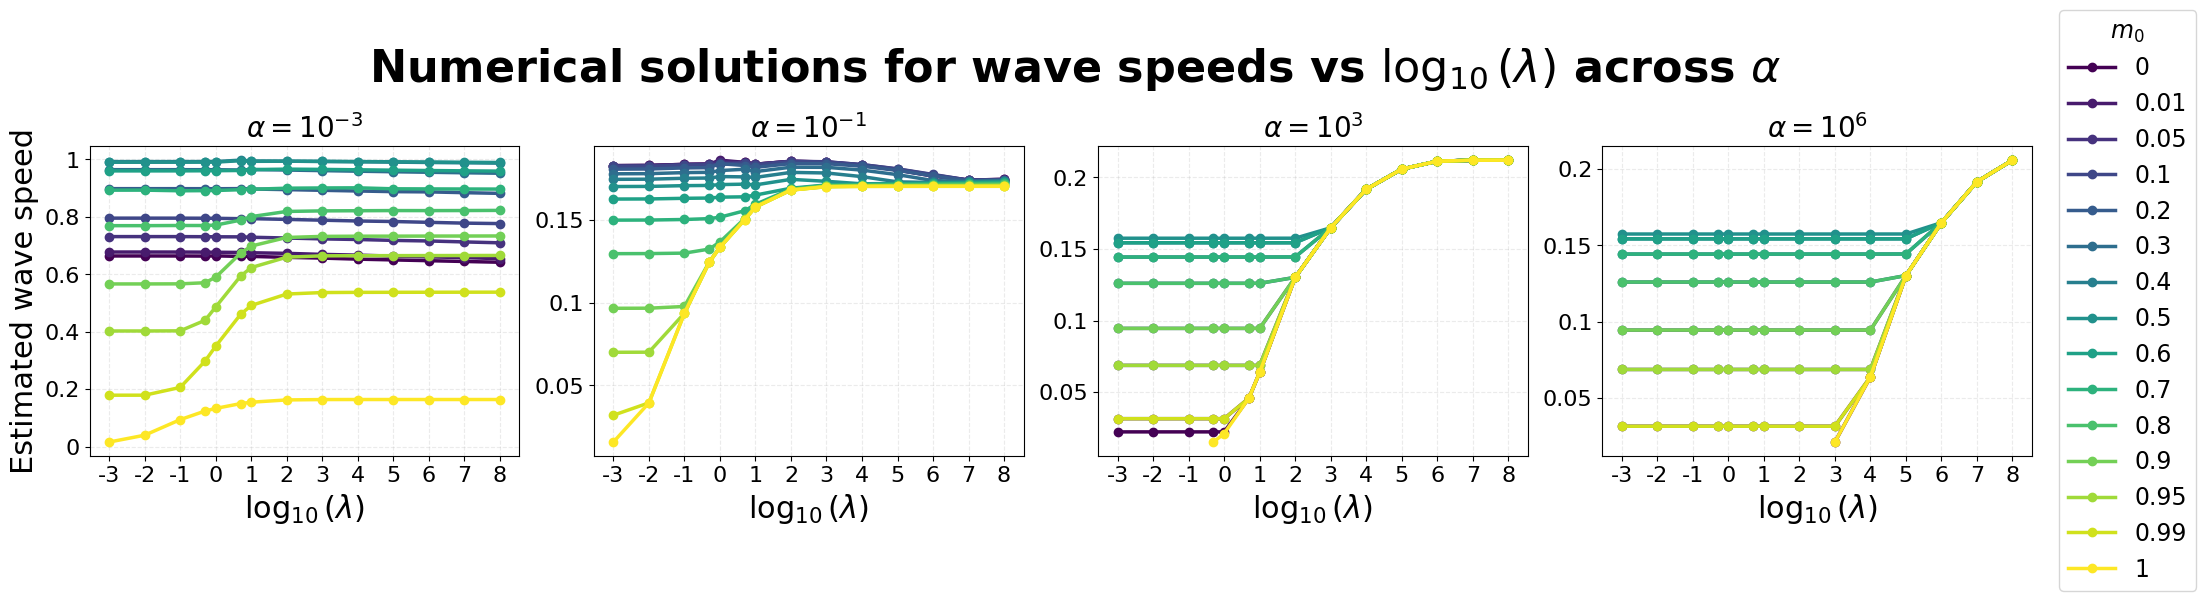

In [4]:
plot_lambda_lines_by_m0_grid(
    base_dirs=("speeds_func_l","speeds_func_u","speeds_func_4"),
    alphas=(1e-3, 1e-1, 1e3, 1e6),
    lambda_vals=(1e-3,1e-2,1e-1,0.5,1,5,10,100,1e3,1e4,1e5,1e6,1e7,1e8),
    m0_vals=(0,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1),
    which_speed="N",
    cmap="viridis",
    # fonts to match heatmap
    font_scale=1.0,
    tick_fs=16, label_fs=22, title_fs=20, legend_fs=17,
    # legend on the right
    legend_side="right",
    legend_bbox_right=(.95, 0.5),
    # raised, bold title
    suptitle=r"Numerical solutions for wave speeds vs $\log_{10}(\lambda)$ across $\alpha$",
    suptitle_y=1.03,
    suptitle_weight="bold",
    sharey=False,
    save=True
)

In [5]:
# === Minimal grid plotter (fix one param, sweep the other; one curve per m0) ===
import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ---- defaults ----
DEFAULT_LAMBDAS = (1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8)
DEFAULT_ALPHAS  = (1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8)
DEFAULT_M0S     = (0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1)

# ---- tiny helpers: token match + dir search ----
_num_pat = re.compile(r"([0-9eE.\-]+)$")

def _token_variants(v: float):
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5-style
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    if not parent.exists(): return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands: return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        try: return float(m.group(1)) if m else None
        except: return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p,v) for p,v in pairs if v is not None]
    if not pairs: return None
    return min(pairs, key=lambda pv: abs(pv[1]-float(target)))[0]

def _augment_roots_by_m0(base_dirs, m0: float):
    """Put patch dir first if present, then prefer *_u for m0>=.5 else *_l."""
    if isinstance(base_dirs, (str, os.PathLike)): base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    if os.path.isdir("speeds_func_4"):
        roots = ["speeds_func_4"] + roots
    want  = "speeds_func_u" if float(m0) >= 0.5 else "speeds_func_l"
    other = "speeds_func_l" if want == "speeds_func_u" else "speeds_func_u"
    ordered = [r for r in (want, other) if r in roots] + [r for r in roots if r not in (want, other)]
    # de-dup preserving order
    seen, out = set(), []
    for r in ordered:
        if r not in seen: seen.add(r); out.append(r)
    return tuple(out)

def _summary_speed(run_dir: Path, which="N"):
    if run_dir is None: return np.nan
    s = run_dir / "summary.json"
    if not s.exists(): return np.nan
    try:
        meta = json.loads(s.read_text())
        keys = ("speed_N","c_N","wave_speed","speed","c") if str(which).upper()=="N" \
               else ("speed_M","c_M","wave_speed","speed","c")
        for k in keys:
            if k in meta:
                try:
                    v = float(meta[k])
                    if np.isfinite(v): return v
                except: pass
    except: pass
    return np.nan

def _find_dir(roots, lam, alpha, m0):
    """<root>/lambda_*/alpha_*/m0_* with exactish tokens; lambda/alpha may use numeric nearest as fallback."""
    roots = _augment_roots_by_m0(roots, m0)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None: continue
        a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None: continue
        m_dir = _exactish_dir(a_dir, "m0", m0)   # m0 must match exactly-ish
        if m_dir is not None: return m_dir
    return None

# ---- pretty titles with special-casing ----
def _lambda_title(lam):
    lam = float(lam)
    if lam == 0:
        return r"$\lambda=0$"
    # special cases: show plain numbers for 10^0 and 10^1
    if np.isclose(lam, 1.0):  return r"$\lambda=1$"
    if np.isclose(lam, 10.0): return r"$\lambda=10$"
    exp = int(np.floor(np.log10(abs(lam))))
    mant = abs(lam) / (10**exp)
    if np.isclose(mant, 1.0, rtol=1e-10, atol=1e-12):
        return rf"$\lambda=10^{{{exp}}}$"
    if 1e-2 <= abs(lam) <= 1e2:
        return rf"$\lambda={lam:g}$"
    return rf"$\lambda={mant:.2g}\times 10^{{{exp}}}$"

def _alpha_title(alpha):
    alpha = float(alpha)
    if alpha == 0: return r"$\alpha=0$"
    if np.isclose(alpha, 1.0):  return r"$\alpha=1$"   # 10^0
    if np.isclose(alpha, 10.0): return r"$\alpha=10$"  # 10^1
    exp = int(np.floor(np.log10(abs(alpha))))
    mant = abs(alpha) / (10**exp)
    if np.isclose(mant, 1.0, rtol=1e-10, atol=1e-12):
        return rf"$\alpha=10^{{{exp}}}$"
    if 1e-2 <= abs(alpha) <= 1e2:
        return rf"$\alpha={alpha:g}$"
    return rf"$\alpha={mant:.2g}\times 10^{{{exp}}}$"

# ---- general grid plotter ----
def plot_speed_vs_log_param_grid(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    param="alpha",                        # "alpha" or "lambda" (what goes on the x-axis)
    fixed_values=(1e-1, 1, 1e2, 1e4),     # one subplot per fixed OTHER param
    sweep_values=None,                    # values for the x-axis; defaults below
    m0_vals=DEFAULT_M0S,
    which_speed="N",
    cmap_name="viridis",
    # fonts/legend to match your other grid
    tick_fs=16, label_fs=22, title_fs=20, legend_fs=17,
    legend_side="right", legend_bbox_right=(0.95, 0.5), legend_bbox_bottom=(0.5, -0.06), legend_ncol_bottom=8,
    suptitle=None, suptitle_y=1.03, suptitle_weight="bold",
    save=False, outpath=None, warn_missing=True
):
    """
    1×N grid:
      - if param="alpha": each subplot fixes λ in fixed_values, x-axis sweeps α
      - if param="lambda": each subplot fixes α in fixed_values, x-axis sweeps λ
    One curve per m0.
    """
    param = str(param).lower().strip()
    if param not in ("alpha", "lambda"):
        raise ValueError("param must be 'alpha' or 'lambda'")

    if sweep_values is None:
        sweep_values = DEFAULT_ALPHAS if param == "alpha" else DEFAULT_LAMBDAS

    sweep_vals = np.asarray(sweep_values, float)
    logx  = np.log10(sweep_vals)

    ncols = len(fixed_values)
    fig, axes = plt.subplots(1, ncols, figsize=(5.4*ncols, 4.8), squeeze=False)
    axes = axes[0]

    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / max(1, len(m0_vals)-1)) for i in range(len(m0_vals))]

    handles, labels = [], []
    total_missing = 0

    for j, fixed in enumerate(fixed_values):
        ax = axes[j]

        for k, m0 in enumerate(m0_vals):
            ys = []
            roots_m0 = _augment_roots_by_m0(base_dirs, m0)
            for s in sweep_vals:
                lam   = fixed if param == "alpha"  else s
                alpha = s     if param == "alpha"  else fixed
                d = _find_dir(roots_m0, lam, alpha, m0)
                c = _summary_speed(d, which=which_speed)
                ys.append(c if np.isfinite(c) else np.nan)
                if not np.isfinite(c):
                    total_missing += 1
                    if warn_missing:
                        print(f"[warn] missing: λ={lam:g}, α={alpha:g}, m0={m0:g} (searched {len(roots_m0)} roots)")
            h, = ax.plot(logx, np.asarray(ys, float), "-o",
                         color=colors[k], lw=2.5, ms=6, label=rf"{m0:g}")
            if j == 0:
                handles.append(h); labels.append(rf"{m0:g}")

        # titles / labels
        if param == "alpha":
            ax.set_title(_lambda_title(fixed), fontsize=title_fs, fontweight="bold")
            ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
        else:
            ax.set_title(_alpha_title(fixed), fontsize=title_fs, fontweight="bold")
            ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)

        if j == 0:
            ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)

        # y ticks to 2 decimals
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(lambda x, _: f"{x:.2f}".rstrip("0").rstrip("."))
        )
        ax.tick_params(axis="both", labelsize=tick_fs)

        # ---- integer decade ticks on the x-axis (like your other plot) ----
        xticks = np.arange(np.floor(min(logx)), np.ceil(max(logx)) + 1).astype(int)
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{d:d}" for d in xticks], fontsize=tick_fs)

        ax.grid(True, linestyle="--", alpha=0.25)

    # shared legend
    if legend_side.lower() == "right":
        fig.legend(handles, labels, title=r"$m_0$",
                   fontsize=legend_fs, title_fontsize=legend_fs,
                   loc="center left", bbox_to_anchor=legend_bbox_right)
        fig.tight_layout(rect=[0, 0, 0.95, 0.92])
    else:
        fig.legend(handles, labels, title=r"$m_0$",
                   fontsize=legend_fs, title_fontsize=legend_fs,
                   loc="upper center", bbox_to_anchor=legend_bbox_bottom, ncol=legend_ncol_bottom)
        fig.tight_layout(rect=[0, 0.07, 1, 0.92])

    # figure title
    if suptitle is None:
        suptitle = (r"Wave speed $c$ vs $\alpha$ at fixed $\lambda$"
                    if param == "alpha" else
                    r"Wave speed $c$ vs $\lambda$ at fixed $\alpha$")
    fig.suptitle(suptitle, fontsize=label_fs + 10, y=suptitle_y, fontweight=suptitle_weight)

    if save:
        outpath = outpath or ("speed_vs_log_alpha_for_lambdas_grid.png" if param == "alpha"
                              else "speed_vs_log_lambda_for_alphas_grid.png")
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    if total_missing and warn_missing:
        print(f"[info] missing/NaN points: {total_missing}")

    return fig, axes

[warn] missing: λ=0.1, α=100000, m0=0 (searched 3 roots)
[warn] missing: λ=0.1, α=1e+06, m0=0 (searched 3 roots)
[warn] missing: λ=0.1, α=1e+07, m0=0 (searched 3 roots)
[warn] missing: λ=0.1, α=1e+08, m0=0 (searched 3 roots)
[warn] missing: λ=0.1, α=1000, m0=1 (searched 3 roots)
[warn] missing: λ=0.1, α=100000, m0=1 (searched 3 roots)
[warn] missing: λ=0.1, α=1e+06, m0=1 (searched 3 roots)
[warn] missing: λ=0.1, α=1e+07, m0=1 (searched 3 roots)
[warn] missing: λ=0.1, α=1e+08, m0=1 (searched 3 roots)
[warn] missing: λ=1, α=100000, m0=0 (searched 3 roots)
[warn] missing: λ=1, α=1e+06, m0=0 (searched 3 roots)
[warn] missing: λ=1, α=1e+07, m0=0 (searched 3 roots)
[warn] missing: λ=1, α=1e+08, m0=0 (searched 3 roots)
[warn] missing: λ=1, α=100000, m0=1 (searched 3 roots)
[warn] missing: λ=1, α=1e+06, m0=1 (searched 3 roots)
[warn] missing: λ=1, α=1e+07, m0=1 (searched 3 roots)
[warn] missing: λ=1, α=1e+08, m0=1 (searched 3 roots)
[warn] missing: λ=10, α=100000, m0=0 (searched 3 roots)
[warn

(<Figure size 2160x480 with 4 Axes>,
 array([<Axes: title={'center': '$\\lambda=10^{-1}$'}, xlabel='$\\log_{10}(\\alpha)$', ylabel='Wave speed $c$'>,
        <Axes: title={'center': '$\\lambda=1$'}, xlabel='$\\log_{10}(\\alpha)$'>,
        <Axes: title={'center': '$\\lambda=10$'}, xlabel='$\\log_{10}(\\alpha)$'>,
        <Axes: title={'center': '$\\lambda=10^{4}$'}, xlabel='$\\log_{10}(\\alpha)$'>],
       dtype=object))

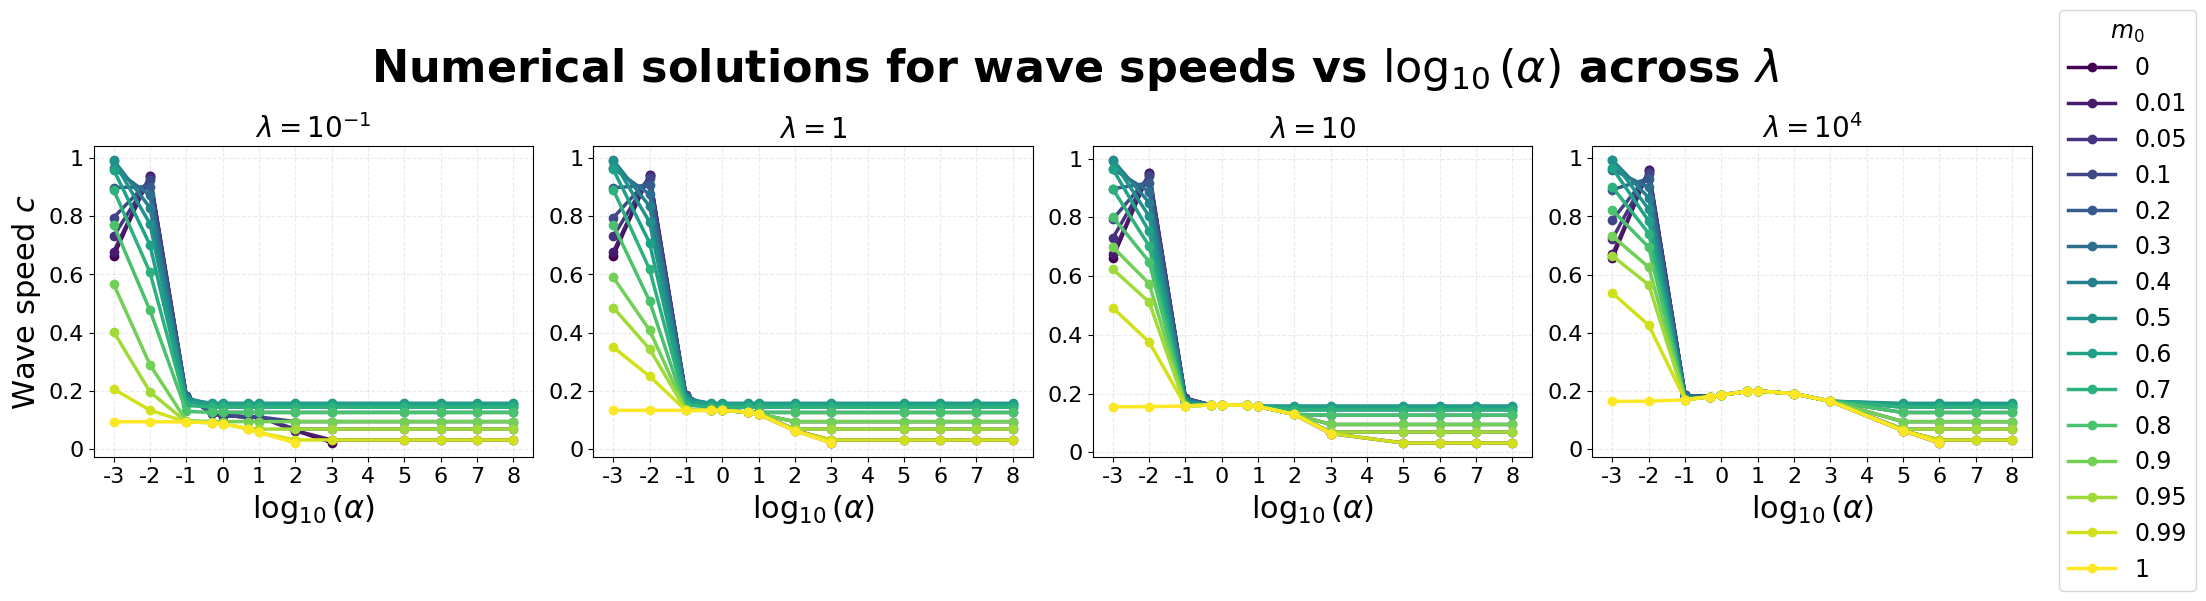

In [6]:
plot_speed_vs_log_param_grid(
    base_dirs=("speeds_func_l","speeds_func_u","speeds_func_4"),
    param="alpha",                                 # sweep α on x-axis
    fixed_values=(1e-1, 1, 1e1, 1e4),              # one subplot per λ
    sweep_values=DEFAULT_ALPHAS,
    m0_vals=DEFAULT_M0S,
    cmap_name="viridis",
    tick_fs=16, label_fs=22, title_fs=20, legend_fs=17,
    legend_side="right", legend_bbox_right=(0.95, 0.5),
    suptitle=r"Numerical solutions for wave speeds vs $\log_{10}(\alpha)$ across $\lambda$",
    save=True
)

In [11]:
def plot_heatmap_alpha_lambda_for_m0s(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    m0_vals=(0.0, 0.5, 1.0),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    alpha_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    which_speed="N",
    cmap="viridis",
    levels=20,
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=17,
    suptitle=r"Heatmap of numerical solutions of wave speeds vs $\log_{10}(\lambda)$ and $\log_{10}(\alpha)$ across $m_0$",
    suptitle_y=0.98,
    cbar_label="Estimated wave speed",
    fig_size=None,
    save=False, outpath=None,
    debug=False
):
    roots = _augment_roots(base_dirs)

    lambda_vals = np.asarray(lambda_vals, float)
    alpha_vals  = np.asarray(alpha_vals,  float)
    X, Y = np.meshgrid(np.log10(lambda_vals), np.log10(alpha_vals))

    # collect missing points to print later
    missing = []   # list of (m0, alpha, lambda)

    ncols = len(m0_vals)
    if fig_size is None:
        fig_size = (6.0 * ncols, 4.8)
    fig, axes = plt.subplots(1, ncols, figsize=fig_size, squeeze=False)
    axes = axes[0]

    for j, m0 in enumerate(m0_vals):
        ax = axes[j]
        H = np.full((len(alpha_vals), len(lambda_vals)), np.nan, float)

        for i, a in enumerate(alpha_vals):
            for k, lam in enumerate(lambda_vals):
                val = _merge_speed_from_roots(roots, lam, a, float(m0), which=which_speed)
                if not np.isfinite(val):
                    missing.append((float(m0), float(a), float(lam)))
                H[i, k] = val

        Hm = np.ma.masked_invalid(H)

        if np.isfinite(Hm).any():
            vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
            if vmin == vmax:
                vmax = vmin + 1e-9
        else:
            vmin, vmax = 0.0, 1.0

        cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

        cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
        ticks = [vmin,
                 vmin + (vmax - vmin) / 3.0,
                 vmin + 2.0 * (vmax - vmin) / 3.0,
                 vmax]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{float(t):.2f}" for t in ticks])
        cbar.ax.tick_params(labelsize=cbar_fs)
        cbar.set_label(cbar_label, fontsize=cbar_fs)

        ax.set_title(rf"$m_0={float(m0):g}$", fontsize=title_fs)

        ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
        if j == 0:
            ax.set_ylabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)

        # decade ticks; show every other on BOTH axes
        xticks_all = np.unique(np.floor(np.log10(lambda_vals)).astype(int))
        yticks_all = np.unique(np.floor(np.log10(alpha_vals)).astype(int))
        xticks = xticks_all[::2]
        yticks = yticks_all[::2]

        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_xticklabels([f"{d:d}" for d in xticks], fontsize=tick_fs)
        ax.set_yticklabels([f"{d:d}" for d in yticks], fontsize=tick_fs)

    if suptitle:
        fig.suptitle(suptitle, fontsize=label_fs + 10, fontweight="bold", y=suptitle_y)

    fig.tight_layout(rect=[0, 0, 1, 0.93 if suptitle else 1])

    if save:
        outpath = outpath or "heatmap_alpha_lambda_by_m0.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    # print missing combos (grouped by m0 for readability)
    if missing:
        print(f"[info] missing/NaN points: {len(missing)}")
        by_m0 = {}
        for m0,a,lam in missing:
            by_m0.setdefault(m0, []).append((a, lam))
        for m0, pairs in by_m0.items():
            pairs_sorted = sorted(pairs, key=lambda p: (p[0], p[1]))
            print(f"  m0={m0:g}: " +
                  ", ".join([f"(α={a:g}, λ={lam:g})" for a, lam in pairs_sorted]))

    return fig, axes

[plot] saved to heatmap_alpha_lambda_by_m0.png
[info] missing/NaN points: 85
  m0=0: (α=10000, λ=0.001), (α=10000, λ=0.01), (α=10000, λ=0.1), (α=10000, λ=0.5), (α=10000, λ=1), (α=100000, λ=0.001), (α=100000, λ=0.01), (α=100000, λ=0.1), (α=100000, λ=0.5), (α=100000, λ=1), (α=100000, λ=5), (α=100000, λ=10), (α=1e+06, λ=0.001), (α=1e+06, λ=0.01), (α=1e+06, λ=0.1), (α=1e+06, λ=0.5), (α=1e+06, λ=1), (α=1e+06, λ=5), (α=1e+06, λ=10), (α=1e+06, λ=100), (α=1e+07, λ=0.001), (α=1e+07, λ=0.01), (α=1e+07, λ=0.1), (α=1e+07, λ=0.5), (α=1e+07, λ=1), (α=1e+07, λ=5), (α=1e+07, λ=10), (α=1e+07, λ=100), (α=1e+07, λ=1000), (α=1e+08, λ=0.001), (α=1e+08, λ=0.01), (α=1e+08, λ=0.1), (α=1e+08, λ=0.5), (α=1e+08, λ=1), (α=1e+08, λ=5), (α=1e+08, λ=10), (α=1e+08, λ=100), (α=1e+08, λ=1000), (α=1e+08, λ=10000)
  m0=1: (α=5, λ=0.001), (α=10, λ=0.001), (α=100, λ=0.001), (α=100, λ=0.01), (α=1000, λ=0.001), (α=1000, λ=0.01), (α=1000, λ=0.1), (α=10000, λ=0.001), (α=10000, λ=0.01), (α=10000, λ=0.1), (α=10000, λ=0.5), (α=10

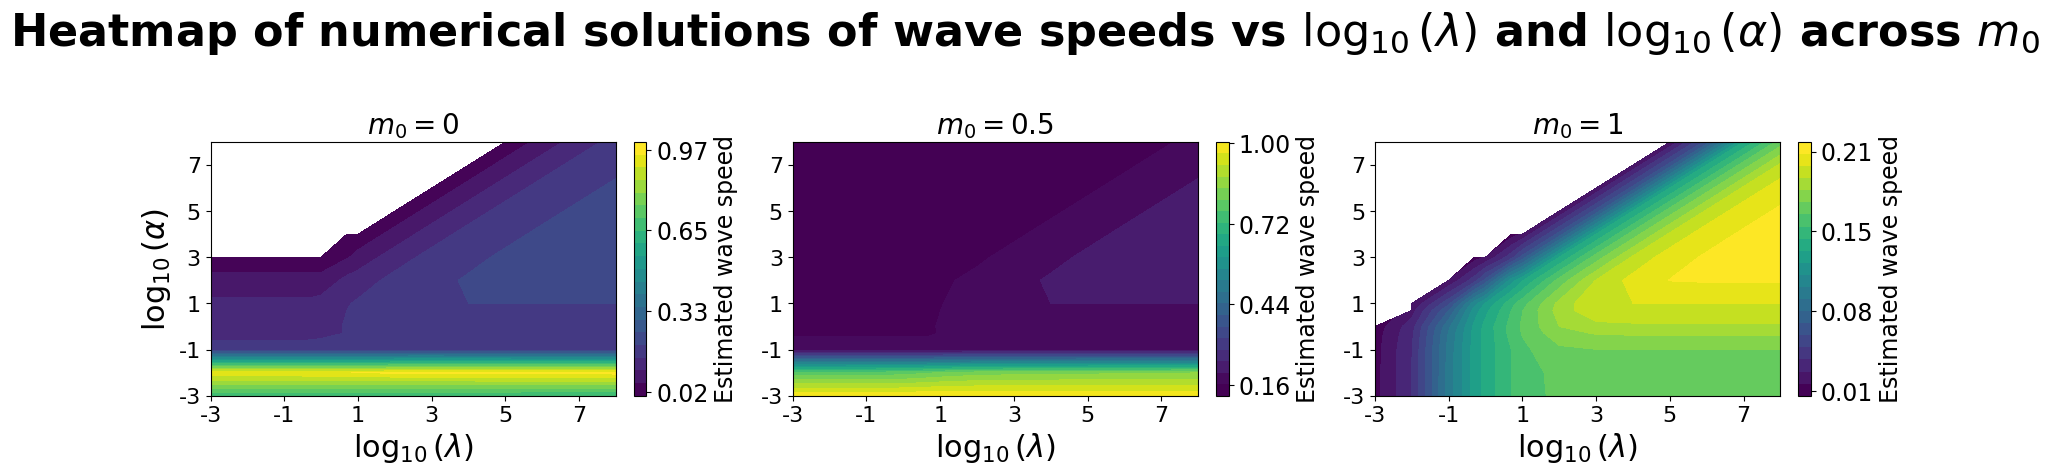

In [12]:
fig, axes = plot_heatmap_alpha_lambda_for_m0s(
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    m0_vals=(0, 0.5, 1),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    alpha_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    which_speed="N",
    cmap="viridis",
    levels=20,
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=17,
    suptitle=r"Heatmap of numerical solutions of wave speeds vs $\log_{10}(\lambda)$ and $\log_{10}(\alpha)$ across $m_0$",
    suptitle_y=0.98,
    cbar_label="Estimated wave speed",
    save=True, outpath="heatmap_alpha_lambda_by_m0.png"
)

[plot] saved to heatmap_alpha_lambda_by_m0.png


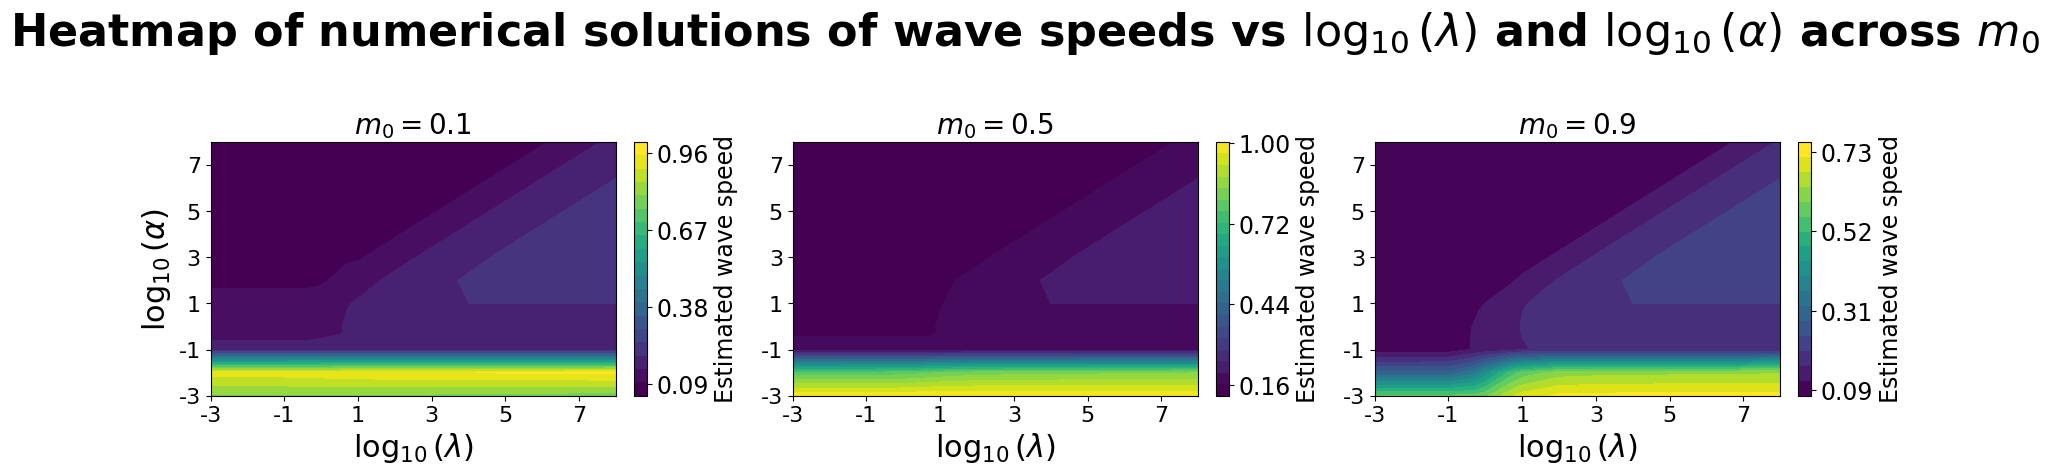

In [34]:
fig, axes = plot_heatmap_alpha_lambda_for_m0s(
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    m0_vals=(0.1, 0.5, 0.9),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    alpha_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8),
    which_speed="N",
    cmap="viridis",
    levels=20,
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=17,
    suptitle=r"Heatmap of numerical solutions of wave speeds vs $\log_{10}(\lambda)$ and $\log_{10}(\alpha)$ across $m_0$",
    suptitle_y=0.98,
    cbar_label="Estimated wave speed",
    save=True, outpath="heatmap_alpha_lambda_by_m0.png"
)

In [13]:
# ===== Area-under-m over time for fixed (lambda, alpha), many m0 curves =====
import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- tiny search helpers (reuse pattern you've been using) ---
_num_pat = re.compile(r"([0-9eE.\-]+)$")

def _token_variants(v: float):
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5-style
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    if not parent.exists(): return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands: return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        try: return float(m.group(1)) if m else None
        except: return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p,v) for p,v in pairs if v is not None]
    if not pairs: return None
    return min(pairs, key=lambda pv: abs(pv[1]-float(target)))[0]

def _augment_roots_by_m0(base_dirs, m0: float):
    """Patch dir first if present, then prefer *_u for m0≥0.5 else *_l."""
    if isinstance(base_dirs, (str, os.PathLike)): base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    if os.path.isdir("speeds_func_4"):
        roots = ["speeds_func_4"] + roots
    want  = "speeds_func_u" if float(m0) >= 0.5 else "speeds_func_l"
    other = "speeds_func_l" if want == "speeds_func_u" else "speeds_func_u"
    ordered = [r for r in (want, other) if r in roots] + [r for r in roots if r not in (want, other)]
    seen, out = set(), []
    for r in ordered:
        if r not in seen: seen.add(r); out.append(r)
    return tuple(out)

def _find_source_dir_multi(roots, lam, alpha, m0):
    """<root>/lambda_*/alpha_*/m0_* (lambda/alpha allow numeric nearest; m0 must exactish)."""
    roots = _augment_roots_by_m0(roots, m0)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None: continue
        a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None: continue
        m_dir = _exactish_dir(a_dir, "m0", m0)   # m0 must match exactly-ish
        if m_dir is not None: return m_dir
    return None

# --- loader + integrator ---
def _load_area_series(run_dir: Path):
    """
    Load snapshots.npz and return (times, area_series) where
    area(t_k) = ∫ m(x, t_k) dx computed by simple trapezoid (uniform grid expected).
    """
    f = Path(run_dir) / "snapshots.npz"
    if not f.is_file():
        return None, None
    z = np.load(f, allow_pickle=True)
    x = z.get("x", None)
    M = z.get("M_arr", None)
    t = z.get("times", z.get("t", None))
    if x is None or M is None or t is None:
        return None, None
    x = np.asarray(x, float)
    t = np.asarray(t, float)
    M = np.asarray(M, float)  # shape (n_times, n_x)
    # integrate along x for each time
    area = np.trapz(M, x=x, axis=1)
    return t, area

# --- pretty lambda title (matches your style & special-cases 1,10) ---
def _lambda_title(lam):
    lam = float(lam)
    if np.isclose(lam, 1.0):  return r"$\lambda=1$"
    if np.isclose(lam, 10.0): return r"$\lambda=10$"
    if lam == 0: return r"$\lambda=0$"
    exp = int(np.floor(np.log10(abs(lam))))
    mant = abs(lam) / (10**exp)
    if np.isclose(mant, 1.0): return rf"$\lambda=10^{{{exp}}}$"
    if 1e-2 <= abs(lam) <= 1e2: return rf"$\lambda={lam:g}$"
    return rf"$\lambda={mant:.2g}\times 10^{{{exp}}}$"

def _alpha_title(alpha):
    a = float(alpha)
    if np.isclose(a, 1.0):  return r"$\alpha=1$"
    if np.isclose(a, 10.0): return r"$\alpha=10$"
    if a == 0: return r"$\alpha=0$"
    exp = int(np.floor(np.log10(abs(a))))
    mant = abs(a) / (10**exp)
    if np.isclose(mant, 1.0): return rf"$\alpha=10^{{{exp}}}$"
    if 1e-2 <= abs(a) <= 1e2: return rf"$\alpha={a:g}$"
    return rf"$\alpha={mant:.2g}\times 10^{{{exp}}}$"

# --- main plotter ---
def plot_m_area_time_for_m0s(
    *,
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    lambda_val=1.0,
    alpha_val=1.0,
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    normalize=False,   # True -> plot spatial average (area / domain length)
    # styling
    cmap_name="viridis",
    ms=5, lw=2.5,
    tick_fs=14, label_fs=18, title_fs=20, legend_fs=14,
    legend_side="right", legend_bbox_right=(1.02, 0.5), legend_bbox_bottom=(0.5, -0.08), legend_ncol_bottom=8,
    suptitle=None, suptitle_y=1.02, suptitle_weight="bold",
    save=False, outpath=None
):
    """
    Plot ∫ m(x,t) dx vs t for a fixed (λ, α), with one curve per m0.
    Requires snapshots.npz to be present in each run directory.
    """
    fig, ax = plt.subplots(figsize=(9.5, 5.5))

    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / max(1, len(m0_vals)-1)) for i in range(len(m0_vals))]

    handles, labels = [], []
    missing = []

    for k, m0 in enumerate(m0_vals):
        run_dir = _find_source_dir_multi(base_dirs, lambda_val, alpha_val, m0)
        if run_dir is None:
            missing.append((m0, "dir not found"))
            continue

        t, area = _load_area_series(run_dir)
        if t is None or area is None:
            missing.append((m0, "snapshots missing/invalid"))
            continue

        if normalize:
            # spatial average of m (divide by domain length)
            # L ≈ x[-1] - x[0]; we don't have x here, but trapz used x, so area is already integral.
            # Reload x to compute L accurately:
            z = np.load(Path(run_dir) / "snapshots.npz", allow_pickle=True)
            x = np.asarray(z["x"], float)
            L = float(x[-1] - x[0])
            y = area / L
            y_label = r"Spatial average $\langle m \rangle$"
        else:
            y = area
            y_label = r"Area under $m(x,t)$"

        h, = ax.plot(t, y, "-o", color=colors[k], lw=lw, ms=ms, label=rf"{float(m0):g}")
        if k == 0:  # collect once, but all handles are identical styles—OK to collect all
            pass
        handles.append(h); labels.append(rf"{float(m0):g}")

    # Labels & formatting
    ax.set_xlabel("Time $t$", fontsize=label_fs)
    ax.set_ylabel(y_label, fontsize=label_fs)
    ax.tick_params(axis="both", labelsize=tick_fs)
    ax.grid(True, linestyle="--", alpha=0.25)

    # 2-decimal y tick formatting (and trim trailing zeros)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.2f}".rstrip("0").rstrip(".")))

    # Title
    if suptitle is None:
        suptitle = rf"Area under $m(x,t)$ vs time at fixed {_lambda_title(lambda_val)}, {_alpha_title(alpha_val)}"
    fig.suptitle(suptitle, fontsize=title_fs, fontweight=suptitle_weight, y=suptitle_y)

    # Legend
    if legend_side.lower() == "right":
        fig.legend(handles, labels, title=r"$m_0$", fontsize=legend_fs, title_fontsize=legend_fs,
                   loc="center left", bbox_to_anchor=legend_bbox_right, frameon=True)
        fig.tight_layout(rect=[0, 0, 0.90, 0.92])
    else:
        fig.legend(handles, labels, title=r"$m_0$", fontsize=legend_fs, title_fontsize=legend_fs,
                   loc="upper center", bbox_to_anchor=legend_bbox_bottom, ncol=legend_ncol_bottom, frameon=True)
        fig.tight_layout(rect=[0, 0.08, 1, 0.92])

    if save:
        outpath = outpath or f"area_m_vs_time_lam{lambda_val:g}_alpha{alpha_val:g}.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    # report anything missing
    if missing:
        print(f"[info] missing series for {len(missing)} m0 values:")
        for m0, reason in missing:
            print(f"  m0={m0:g}: {reason}")

    return fig, ax

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_3870/1972327297.py:86: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(M, x=x, axis=1)


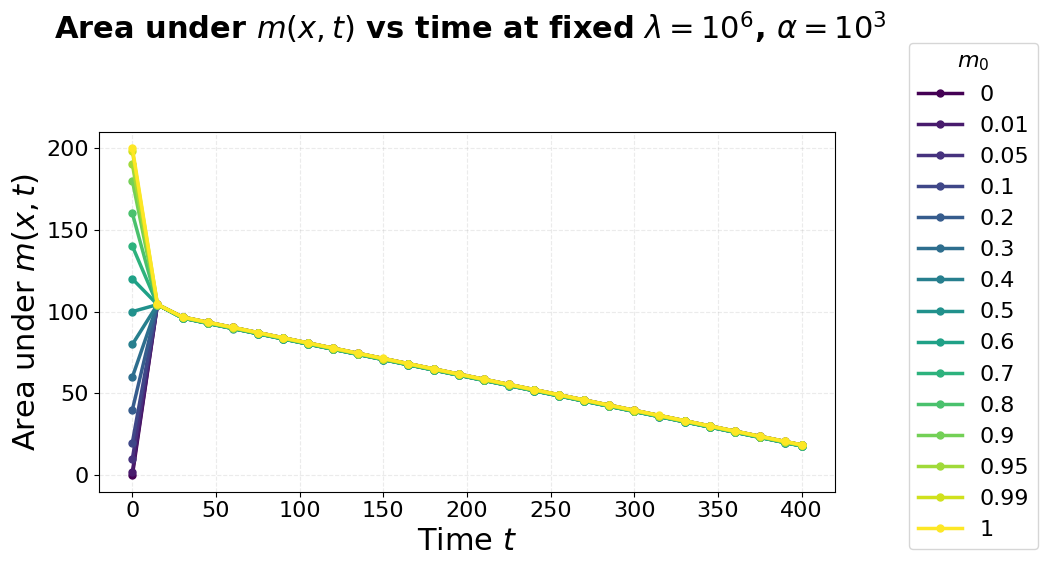

(<Figure size 950x550 with 1 Axes>,
 <Axes: xlabel='Time $t$', ylabel='Area under $m(x,t)$'>)

In [19]:
# Example: fixed (λ, α) = (10, 1e3), show all default m0 curves
plot_m_area_time_for_m0s(
    base_dirs=("speeds_func_l", "speeds_func_u", "speeds_func_4"),
    lambda_val=1e6,
    alpha_val=1e3,
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    normalize=False,     # set True to plot spatial average <m> instead of area
    cmap_name="viridis",
    tick_fs=16, label_fs=22, title_fs=22, legend_fs=16,
    legend_side="right", legend_bbox_right=(0.95, 0.5),
    suptitle=None,       # auto-builds a nice title with λ and α formatting
    save=False
)

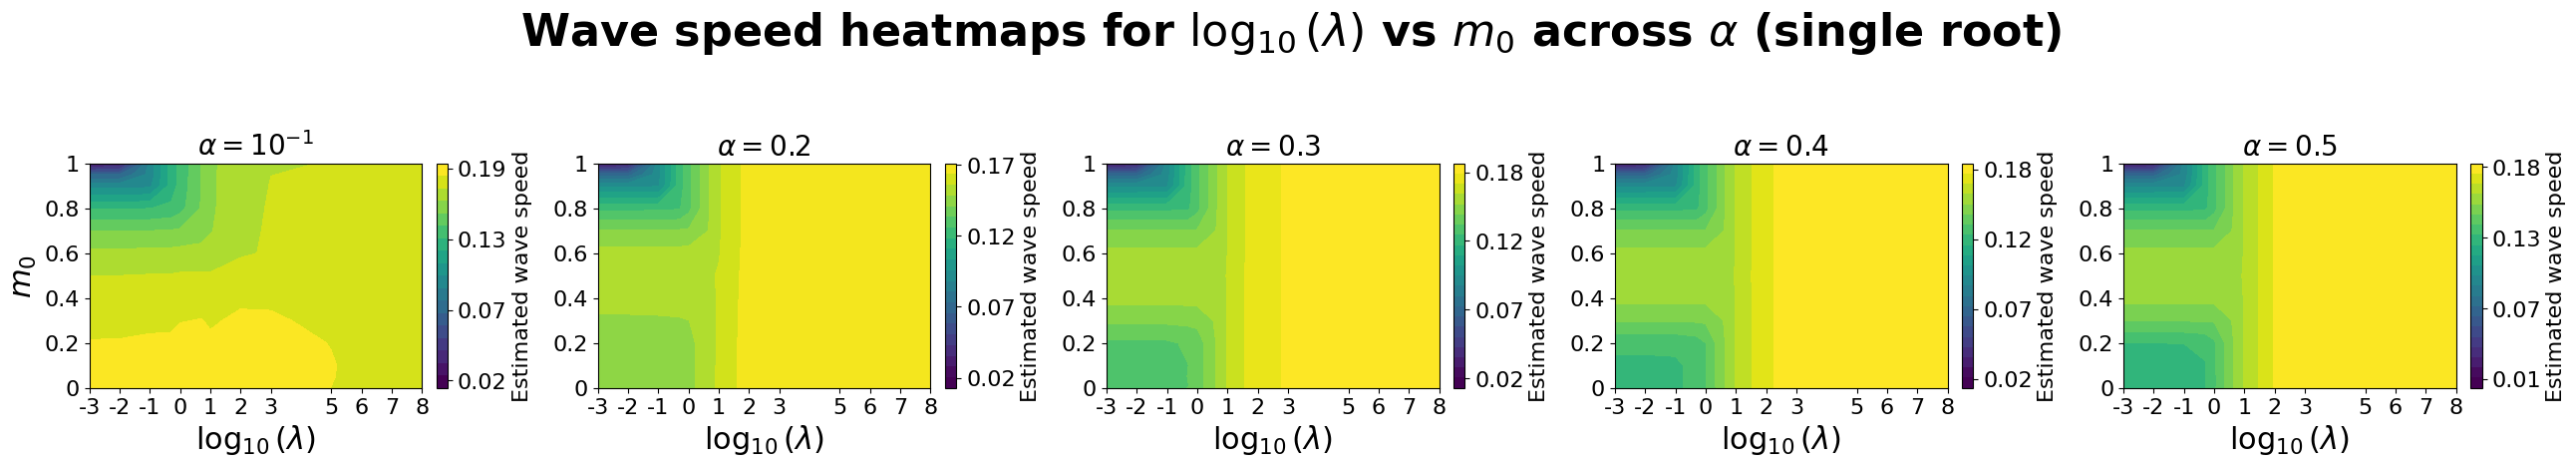

In [37]:
# === Wave-speed heatmaps for fixed α values (single root) =====================
# - Robust token matching: accepts 1e8, 1e+08, 1e08, 100000000, "p" decimals, E/ e.
# - Numeric fallback if exactish token not found.
# - 1×K grid over α in a single root like "speeds_func_alpha_01".
# ==============================================================================

import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Token + directory helpers
# ------------------------
_num_pat = re.compile(r"([0-9eE\.\+\-]+)$")

def _token_variants(v: float):
    """Return many textual variants for v to match folder tokens."""
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")         # 100000000
    plain = f"{v:g}"                                    # 1e+08 or 100000000 (matplotlib-style)
    sci   = f"{v:.0e}"                                  # 1e+08
    s, e  = sci.split("e")
    ei    = int(e)                                      # 8 (or -8)
    sci_neat   = f"{s}e{ei}"                            # 1e8
    sci_zpad   = f"{s}e{abs(ei):02d}"                   # 1e08
    sci_sign   = f"{s}e{'+' if ei>=0 else '-'}{abs(ei):02d}"  # 1e+08 / 1e-08

    toks = {dec, plain, sci, sci_neat, sci_zpad, sci_sign}
    # uppercase E variants
    toks |= {t.replace("e", "E") for t in list(toks)}
    # allow decimal "p" variant (e.g., 0p5)
    toks |= {t.replace(".", "p") for t in list(toks)}
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    """Return parent/prefix_<token> if any token matches exactly (string)."""
    if not parent.exists():
        return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir():
            return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    """Numeric fallback (only used if exactish failed)."""
    if not parent.exists():
        return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands:
        return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        if not m:
            return None
        s = m.group(1).replace("p", ".")
        # normalize e/E with optional + sign (float handles both)
        try:
            return float(s)
        except Exception:
            return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p, v) for p, v in pairs if v is not None]
    if not pairs:
        return None
    return min(pairs, key=lambda pv: abs(pv[1] - float(target)))[0]

# ------------------------
# Speed loader
# ------------------------
def _summary_speed(run_dir: Path, which="N"):
    if run_dir is None:
        return np.nan
    s = run_dir / "summary.json"
    if not s.exists():
        return np.nan
    try:
        meta = json.loads(s.read_text())
    except Exception:
        return np.nan

    w = str(which).upper()
    keys = ["wave_speed", "speed", "c"]               # generic fallbacks
    if w == "N":
        keys = ["speed_N", "c_N"] + keys
    else:
        keys = ["speed_M", "c_M"] + keys

    for k in keys:
        if k in meta:
            try:
                v = float(meta[k])
                if np.isfinite(v):
                    return v
            except Exception:
                pass
    return np.nan

# ------------------------
# Single-root dir resolver
# ------------------------
def _find_dir_single_root(root_dir, lam, alpha, m0):
    """
    Resolve <root>/lambda_*/alpha_*/m0_* inside a single base folder.
    - tries exactish tokens first,
    - then numeric nearest for lambda and alpha,
    - m0 must match exactish (no nearest).
    """
    base = Path(root_dir)
    lam_dir = (_exactish_dir(base, "lambda", lam) or
               _closest_dir_by_number(base, "lambda", lam))
    if lam_dir is None:
        return None
    a_dir = (_exactish_dir(lam_dir, "alpha", alpha) or
             _closest_dir_by_number(lam_dir, "alpha", alpha))
    if a_dir is None:
        return None
    m_dir = _exactish_dir(a_dir, "m0", m0)  # exactish only for m0
    return m_dir

# ------------------------
# Plotter: 1×K grid over α
# ------------------------
def plot_alpha_grid_from_single_root(
    *,
    root_dir="speeds_func_alpha_01",
    alpha_list=(0.1, 0.2, 0.3, 0.4, 0.5),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="viridis",
    levels=20,
    # fonts & layout
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
    suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
    suptitle_y=1.02,
    every_other_y_tick=True,
    save=False, outpath=None,
    verbose=True
):
    alpha_list = tuple(float(a) for a in alpha_list)
    lam_arr    = np.asarray(lambda_vals, float)
    m0_arr     = np.asarray(m0_vals,     float)

    X, Y = np.meshgrid(np.log10(lam_arr), m0_arr)

    ncols = len(alpha_list)
    fig_w = 5.2 * ncols
    fig_h = 4.5
    fig, axes = plt.subplots(1, ncols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes[0]

    total_missing = 0

    for j, a in enumerate(alpha_list):
        ax = axes[j]
        H = np.full((len(m0_arr), len(lam_arr)), np.nan, float)

        # fill matrix
        for i, m0 in enumerate(m0_arr):
            for k, lam in enumerate(lam_arr):
                d = _find_dir_single_root(root_dir, lam, a, m0)
                c = _summary_speed(d, which=which_speed)
                if np.isfinite(c):
                    H[i, k] = c
                else:
                    total_missing += 1

        Hm = np.ma.masked_invalid(H)
        if np.isfinite(Hm).any():
            vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
            if vmin == vmax:
                vmax = vmin + 1e-12
        else:
            vmin, vmax = 0.0, 1.0

        cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

        # colorbar (4 ticks)
        cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
        ticks = [vmin,
                 vmin + (vmax - vmin) / 3.0,
                 vmin + 2.0 * (vmax - vmin) / 3.0,
                 vmax]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{float(t):.2f}" for t in ticks])
        cbar.ax.tick_params(labelsize=cbar_fs)
        cbar.set_label("Estimated wave speed", fontsize=cbar_fs)

        # title
        if np.isclose(a, 1.0):
            tlabel = r"$\alpha=1$"
        elif np.isclose(a, 10.0):
            tlabel = r"$\alpha=10$"
        else:
            exp = int(np.floor(np.log10(abs(a)))) if a != 0 else 0
            mant = abs(a) / (10**exp) if a != 0 else 0
            if a != 0 and np.isclose(mant, 1.0):
                tlabel = rf"$\alpha=10^{{{exp}}}$"
            elif 1e-2 <= abs(a) <= 1e2:
                tlabel = rf"$\alpha={a:g}$"
            else:
                tlabel = rf"$\alpha={mant:.2g}\times 10^{{{exp}}}$"
        ax.set_title(tlabel, fontsize=title_fs)

        # axes labels
        ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
        if j == 0:
            ax.set_ylabel(r"$m_0$", fontsize=label_fs)

        # ticks: decades on x; every-other on y if requested
        xticks = np.unique(np.floor(np.log10(lam_arr)).astype(int))
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{d:d}" for d in xticks], fontsize=tick_fs)

        yticks = np.linspace(0, 1, 11)  # coarse m0 grid for readability
        if every_other_y_tick:
            yticks = yticks[::2]  # 0, .2, .4, .6, .8, 1
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{y:.2g}" for y in yticks], fontsize=tick_fs)

    if suptitle:
        fig.suptitle(suptitle, fontsize=label_fs + 10, y=suptitle_y, fontweight="bold")

    fig.tight_layout(rect=[0, 0, 1, 0.93 if suptitle else 1])

    if verbose and total_missing:
        print(f"[info] missing/NaN cells encountered: {total_missing}")

    if save:
        outpath = outpath or "alpha_grid_single_root.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    return fig, axes

# ------------------------
# Example call (your case)
# ------------------------
if __name__ == "__main__":
    lambda_vals = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 100000, 1000000, 10000000, 100000000]
    alpha_vals  = [0.1, 0.2, 0.3, 0.4, 0.5]
    m0_vals     = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]

    plot_alpha_grid_from_single_root(
        root_dir="speeds_func_alpha_01",
        alpha_list=alpha_vals,
        lambda_vals=lambda_vals,
        m0_vals=m0_vals,
        which_speed="N",
        cmap="viridis",
        levels=20,
        tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
        suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
        suptitle_y=1.03,
        every_other_y_tick=True,
        save=False,  # set True to write a PNG
        outpath="alpha_grid_single_root.png",
        verbose=True
    )